[쇼핑데이터 EDA, Melanoma Classification EDA](https://www.kaggle.com/code/andradaolteanu/siim-melanoma-competition-eda-augmentations/notebook) 참고

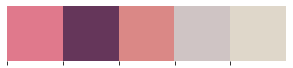

In [1]:
# Regular Imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from pandas import json_normalize

import pydicom # for DICOM images
from skimage.transform import resize

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

# Set Color Palettes for the notebook
colors_nude = ['#e0798c','#65365a','#da8886','#cfc4c4','#dfd7ca']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [2]:
directory = '.'
train_df = pd.read_csv(directory +'/naverboostcamp_train.csv')
test_df = pd.read_csv(directory +'/naverboostcamp_val.csv')
train_df = train_df.replace((-1,-2), np.NaN)
test_df = test_df.replace((-1,-2), np.NaN)

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

Train has 3,398 rows and Test has 577 rows.


In [3]:
df1_styler = train_df.head().style.set_table_attributes("style='display:inline'").set_caption('Head Train Data')
df2_styler = test_df.head().style.set_table_attributes("style='display:inline'").set_caption('Head Test Data')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

,part,oil,sensitive,pigmentation,wrinkle,hydration,file_name
0,1.000000,3.000000,1.000000,nan,0.000000,nan,00000NBC.jpg
1,1.000000,3.000000,1.000000,nan,0.000000,nan,00001NBC.jpg
2,0.000000,4.000000,1.000000,1.000000,nan,nan,00002NBC.jpg
3,0.000000,4.000000,1.000000,1.000000,nan,nan,00003NBC.jpg
4,3.000000,nan,0.000000,nan,1.000000,2.000000,00004NBC.jpg
,part,oil,sensitive,pigmentation,wrinkle,hydration,file_name
0,1.000000,1.000000,0.000000,nan,0.000000,nan,00000NBC_val.jpg
1,1.000000,2.000000,0.000000,nan,0.000000,nan,00001NBC_val.jpg
2,0.000000,1.000000,1.000000,1.000000,nan,nan,00002NBC_val.jpg
3,0.000000,1.000000,1.000000,1.000000,nan,nan,00003NBC_val.jpg


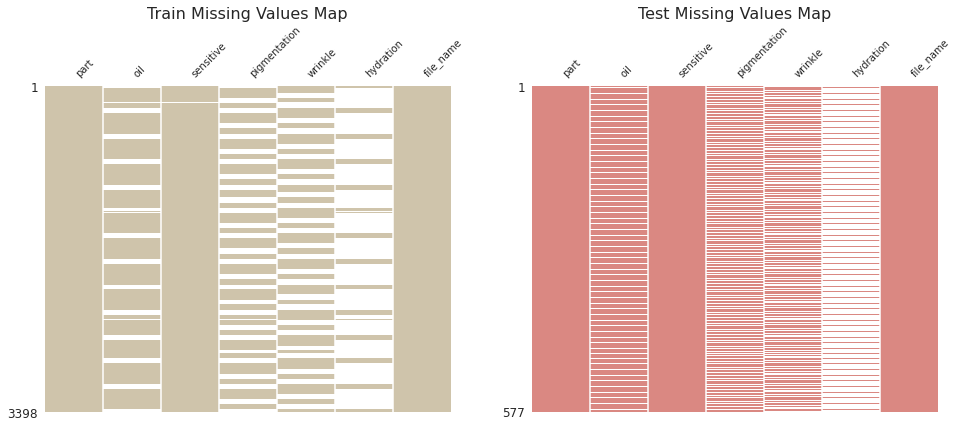

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(207/255, 196/255, 171/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(218/255, 136/255, 130/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

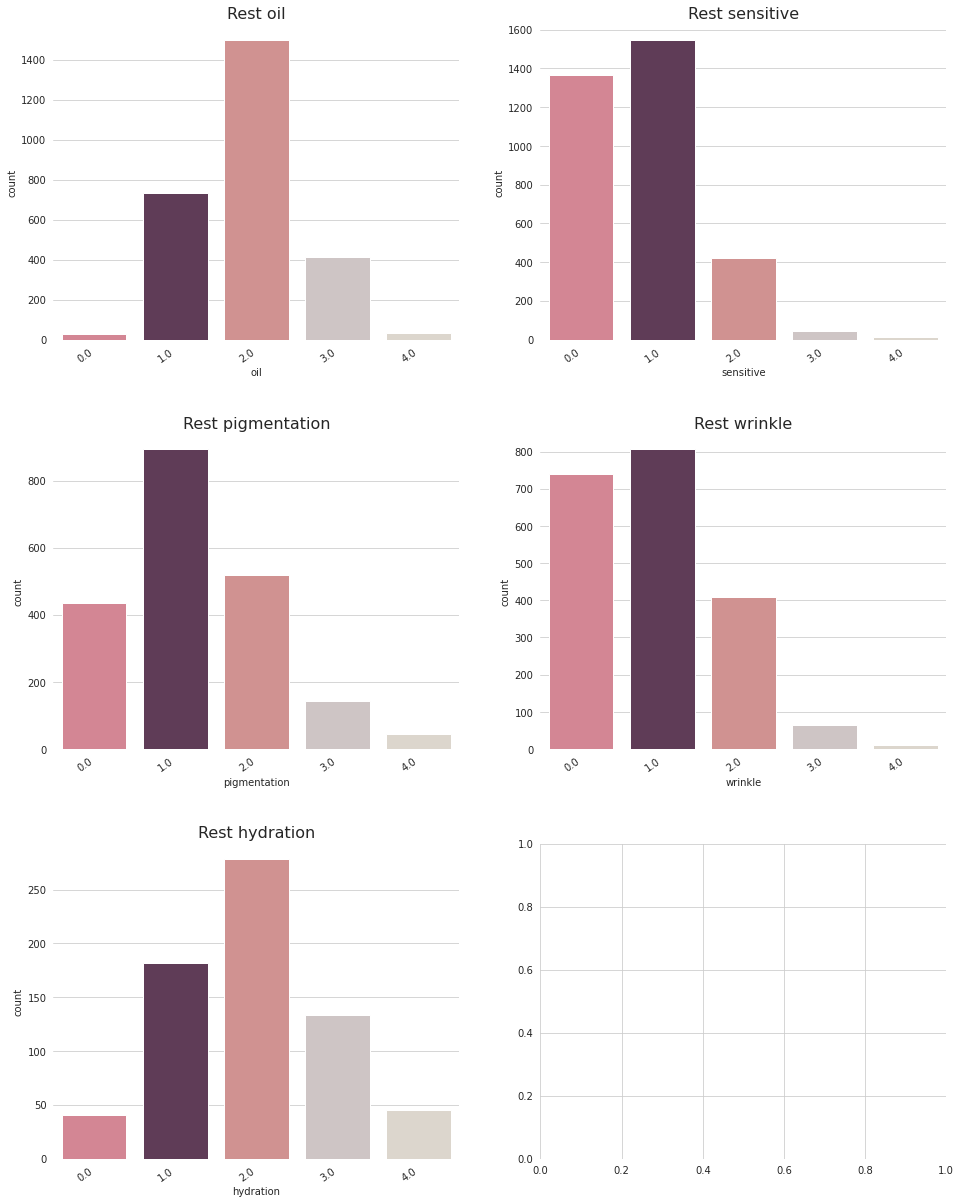

In [5]:
# Data
is_oil = train_df[train_df['oil'].isna() == False]
is_sensitive = train_df[train_df['sensitive'].isna() == False]
is_pigmentation = train_df[train_df['pigmentation'].isna() == False]
is_wrinkle = train_df[train_df['wrinkle'].isna() == False]
is_hydration = train_df[train_df['hydration'].isna() == False]

# Figure
f, axes = plt.subplots(3, 2, figsize = (16, 18))

a = sns.countplot(is_oil['oil'], ax = axes[0][0], palette=colors_nude)
b = sns.countplot(is_sensitive['sensitive'], ax = axes[0][1], palette=colors_nude)
c = sns.countplot(is_pigmentation['pigmentation'], ax = axes[1][0], palette=colors_nude)
d = sns.countplot(is_wrinkle['wrinkle'], ax = axes[1][1], palette=colors_nude)
e = sns.countplot(is_hydration['hydration'], ax = axes[2][0], palette=colors_nude)

axes[0][0].set_title('Rest oil', fontsize=16)
axes[0][1].set_title('Rest sensitive', fontsize=16)
axes[1][0].set_title('Rest pigmentation', fontsize=16)
axes[1][1].set_title('Rest wrinkle', fontsize=16)
axes[2][0].set_title('Rest hydration', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
c.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
d.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
e.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")

plt.subplots_adjust(left=0.125, bottom=0.025, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
sns.despine(left=True, bottom=True);

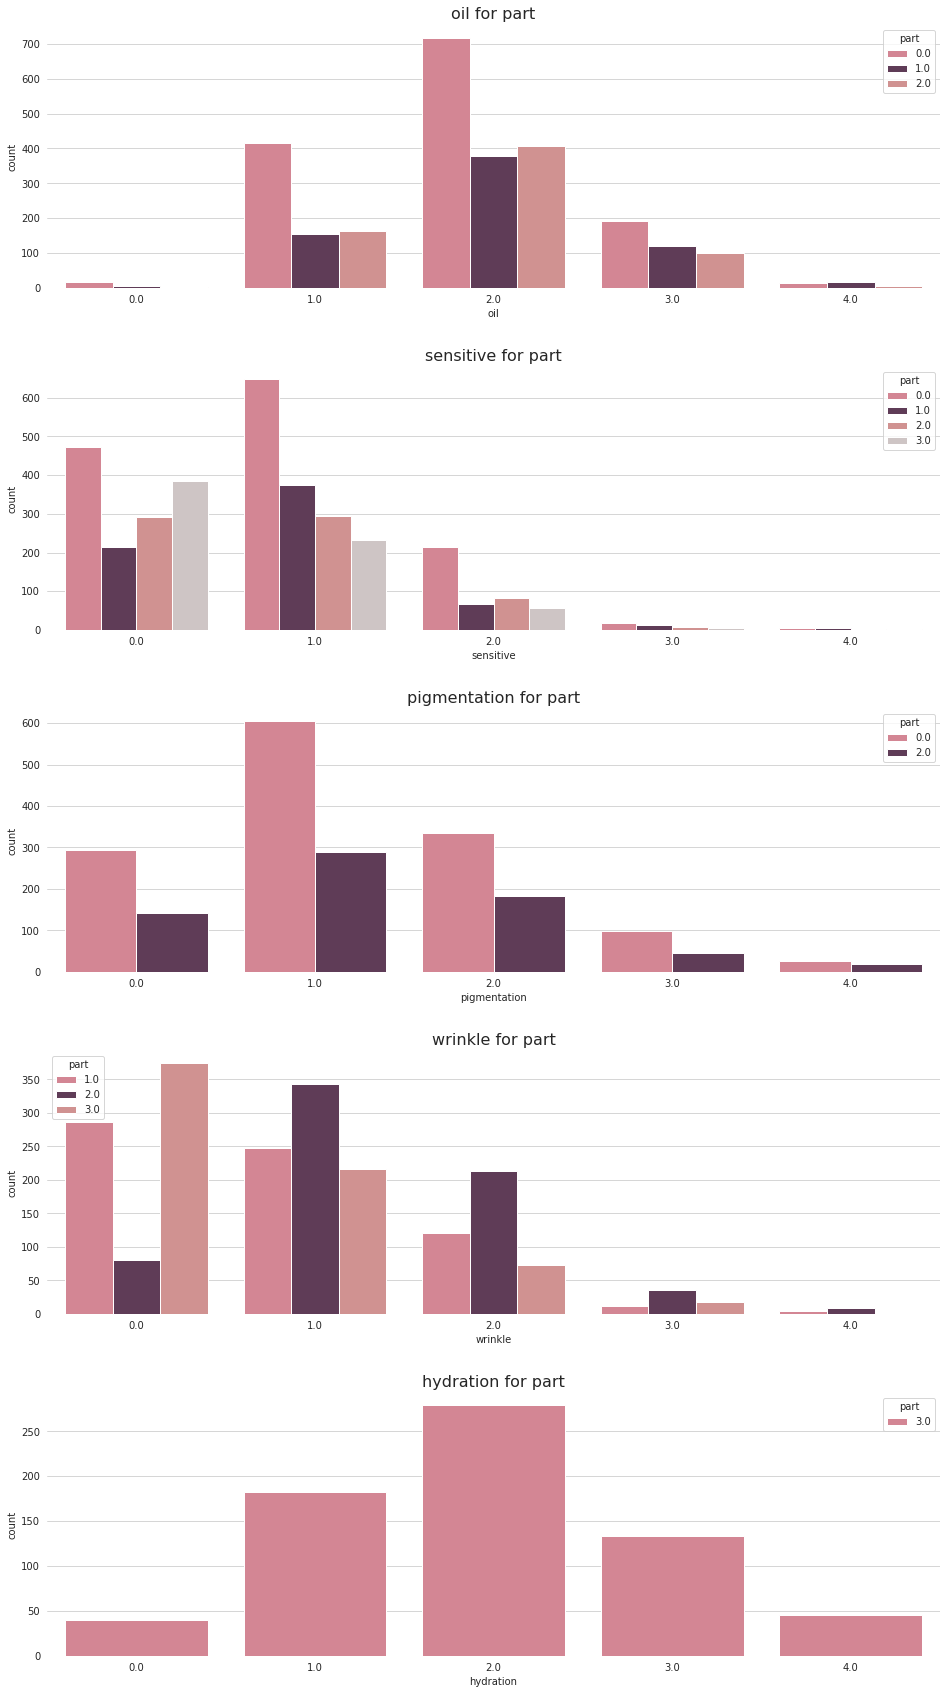

In [6]:
is_oil = train_df[train_df['oil'].isna() == False]
is_sensitive = train_df[train_df['sensitive'].isna() == False]
is_pigmentation = train_df[train_df['pigmentation'].isna() == False]
is_wrinkle = train_df[train_df['wrinkle'].isna() == False]
is_hydration = train_df[train_df['hydration'].isna() == False]

# Figure
f, axes = plt.subplots(5, 1, figsize = (16, 30))

sns.countplot(is_oil['oil'], hue=is_oil['part'], ax=axes[0], palette=colors_nude)
sns.countplot(is_sensitive['sensitive'], hue=is_sensitive['part'], ax=axes[1], palette=colors_nude)
sns.countplot(is_pigmentation['pigmentation'], hue=is_pigmentation['part'], ax=axes[2], palette=colors_nude)
sns.countplot(is_wrinkle['wrinkle'], hue=is_wrinkle['part'], ax=axes[3], palette=colors_nude)
sns.countplot(is_hydration['hydration'], hue=is_hydration['part'], ax=axes[4], palette=colors_nude)

axes[0].set_title('oil for part', fontsize=16)
axes[1].set_title('sensitive for part', fontsize=16)
axes[2].set_title('pigmentation for part', fontsize=16)
axes[3].set_title('wrinkle for part', fontsize=16)
axes[4].set_title('hydration for part', fontsize=16)

sns.despine(left=True, bottom=True);
plt.subplots_adjust(hspace=0.3)


In [7]:
shapes_train = []
path = directory + '/naverboostcamp_train/JPEGImages/'
for k, name in enumerate(train_df['file_name']):
    image = Image.open(path+name)
    shapes_train.append(image.size)
    if k >= 100: break
        
shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='object')
shapes_train['Size'] = '[' + shapes_train['H'].astype(str) + ', ' + shapes_train['W'].astype(str) + ']'